[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hSu6AfQ7wwjLQLx918ro9K_u6QvMDruz?usp=sharing)

#Meta-Estimators in Scikit-learn

## Introduction

In machine learning, we often combine multiple models to get better performance. Scikit-learn provides **meta-estimators** — these are higher-level models that use other models internally to achieve this.

Common meta-estimators include:
- `VotingClassifier` – for combining classifiers.
- `GridSearchCV` – for hyperparameter tuning.
- `Time-Series`

These meta-estimators can:
- Combine multiple models (often in parallel).
- Control and fine-tune hyperparameters.
- Post-process the predictions (e.g., majority vote, average probabilities).

##Basics


###making synthetic dataset

###Importing Essential Libraries

In [58]:
import numpy as np
import matplotlib.pylab as plt

#Calassification model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

#Synthetic Dataset maker
from sklearn.datasets import make_classification


###Creating Synthetic Dataset using make_classification

#### Overview

To train and test our models without relying on external data, we’ll create a synthetic classification dataset using `make_classification` from `sklearn.datasets`.

This function generrates a set of features (`X`) and corresponding labels (`y`) that simulate a binary classification problem.


In [59]:
##Binary dataset
#X=Faeture and y= Target
X, y = make_classification(
    n_samples=2000,        # Generate 2000 samples
    n_features=2,          # 2 numerical features (good for 2D visualization)
    n_redundant=0,         # No redundant features (extra features derived from informative ones)
    class_sep=1.75,        # Controls how clearly the classes are separated
    flip_y=0.1,            # 10% label noise — randomly flip 10% of the labels
    random_state=21        # Seed to make the output reproducible every time you run it
)

###Matplotlib
Before training any model, it's always a good idea to understand the data visually. Since we generated a **2D dataset** (with only 2 features), we can plot the points on a scatter plot to see:
- How the two classes are distributed
- How separable they are
- If there's any overlap or noise

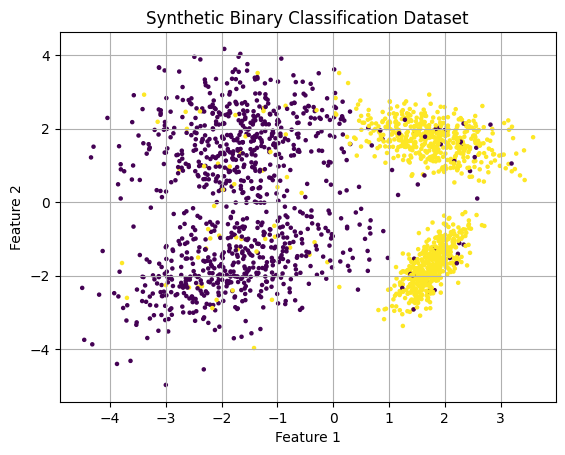

In [60]:
#Representation of scattred features not labels
plt.scatter(X[:, 0], X[:, 1], c=y, s=5) #You're drawing each data point using its two features.
plt.title("Synthetic Binary Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


##Voting Classifier

###Training Individual Classifiers

Before we combine models using a VotingClassifier, let’s first **train the base models individually** on our synthetic dataset. This helps us understand how each one performs and lays the foundation for ensembling.

We’ll train two classifiers:
- **Logistic Regression**
    LogisticRegression(): A linear model suitable for binary classification.
    It models the probability that a given input belongs to a particular class using a sigmoid function.

    .fit(X, y): This is the training step. The model learns from the features X and their corresponding labels y.
- **K-Nearest Neighbors (KNN)**

    KNeighborsClassifier(n_neighbors=5):
    This model assigns a class to a point based on the majority class among its 5 nearest neighbors in the training data.

    The distance metric (usually Euclidean) is used to find the "closest" points.

In [61]:
#Classifier 1
#Logistic Regression

clf1 = LogisticRegression().fit(X, y)

#Classifier 2
#K-Nearest Neigbor (KNN) with 5 neighbor by distance

clf2 = KNeighborsClassifier(n_neighbors=5).fit(X, y)



###Voting Classifier
####Building and Training a VotingClassifier (Meta-Estimator)

####What is a Meta-Estimator?

A **meta-estimator** is a higher-level model that combines other estimators. It **doesn’t learn directly from data**, but instead learns how to **coordinate and combine** the predictions of other models.

One common meta-estimator in classification is `VotingClassifier`.
**`VotingClassifier` specifically works with classifiers**.  

- Meta Estimator can take **2 or more** classifiers as input using the `estimators` parameter.


In [62]:
#Classifier 3:
# Combines clf1 and clf2 predictions

clf3 = VotingClassifier(
    estimators=[('clf1', clf1), ('clf2', clf2)],
    voting='soft', #Making class probabilities as average
    weights=[10.5, 2.5]
)
clf3.fit(X, y)




VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', KNeighborsClassifier())],
                 voting='soft', weights=[10.5, 2.5])

###Matplotlib for Voting Classifier

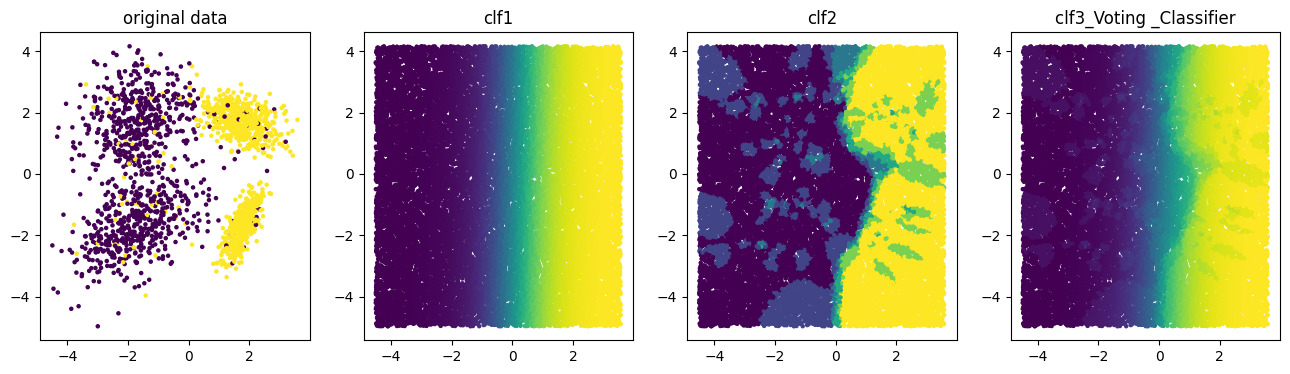

In [63]:
#MAking a matplotlib as a fuction for future use
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)

    plt.figure(figsize=(16, 4))

    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("clf1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("clf2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("clf3_Voting _Classifier")
    plt.show()

make_plots()



##Thresholding
###Thresholding in Classification Models

### Why Thresholding?

Normally, classifiers like `LogisticRegression` predict probabilities and use **0.5 as the default cutoff** to decide between class 0 and 1.

But in some situations (e.g., fraud detection, medical diagnostics), you might want to:
- **Raise the threshold** to reduce false positives.
- **Lower it** to catch more positives (even at the cost of more false alarms).

Scikit-learn doesn't have a native way to do this during training  but `scikit-lego` provides a meta-estimator called `Thresholder`.

###Importing Required Liraries

In [64]:
! pip install scikit-lego
from sklego.meta import Thresholder
#Pipeline
from sklearn.pipeline import Pipeline
#Classification  model
from sklearn.linear_model import LogisticRegression
#Metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score
#Dataset Synthetic
from sklearn.datasets import make_blobs


### Creating a Synthetic Dataset using `make_blobs`

#### Why Use `make_blobs`?

Unlike `make_classification`, which is more abstract and customizable for real-world simulation, `make_blobs` is perfect for **cluster-based datasets**  especially for **visual clarity** when exploring classification behavior and decision thresholds.

Here, we'll generate two clearly defined clusters with different spreads to simulate **class imbalance in separability**.


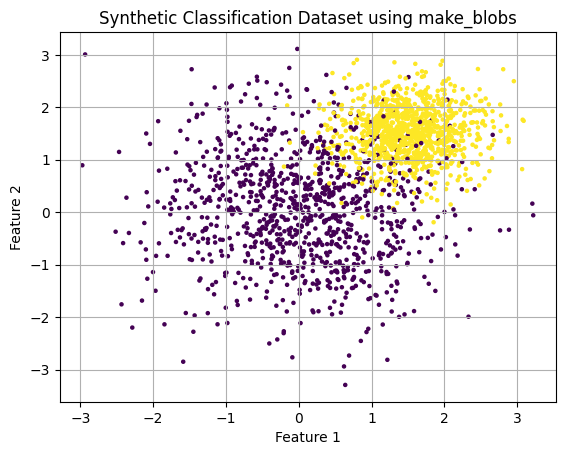

In [65]:
#Synthetic dataset using blob

X, y = make_blobs(
    n_samples=2000,                     # Total samples
    centers=[(0, 0), (1.5, 1.5)],
    cluster_std=[1, 0.5]
)

#MAtplotlib just to see the data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("Synthetic Classification Dataset using make_blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()



### Exploring the Effect of Custom Thresholds

#### Why Use Custom Thresholds?

By default, most classifiers (like `LogisticRegression`) classify a sample as **class 1 if the predicted probability is ≥ 0.5**.

However, we might want to:
- **Lower the threshold (e.g., 0.1)** to increase **sensitivity/recall** (more likely to predict class 1).
- **Raise the threshold (e.g., 0.9)** to increase **specificity/precision** (only predict class 1 when very confident).

This is especially useful in:
- Medical diagnosis
- Fraud detection
- Imbalanced datasets

In [66]:
#Threshold Parameter
m1=Thresholder(model=LogisticRegression(solver='lbfgs'),threshold=0.1).fit(X,y) #solver lbfs=finds the best weight
m2=Thresholder(model=LogisticRegression(solver='lbfgs'),threshold=0.9).fit(X,y)


🧠 Think of it like:

0.1 =Low threshold = model says "I'm willing to call this class 1 even if I'm not very sure."

0.9=High threshold = model says "I'll call this class 1 only if I'm very confident."

###Matplotlib for Threshold

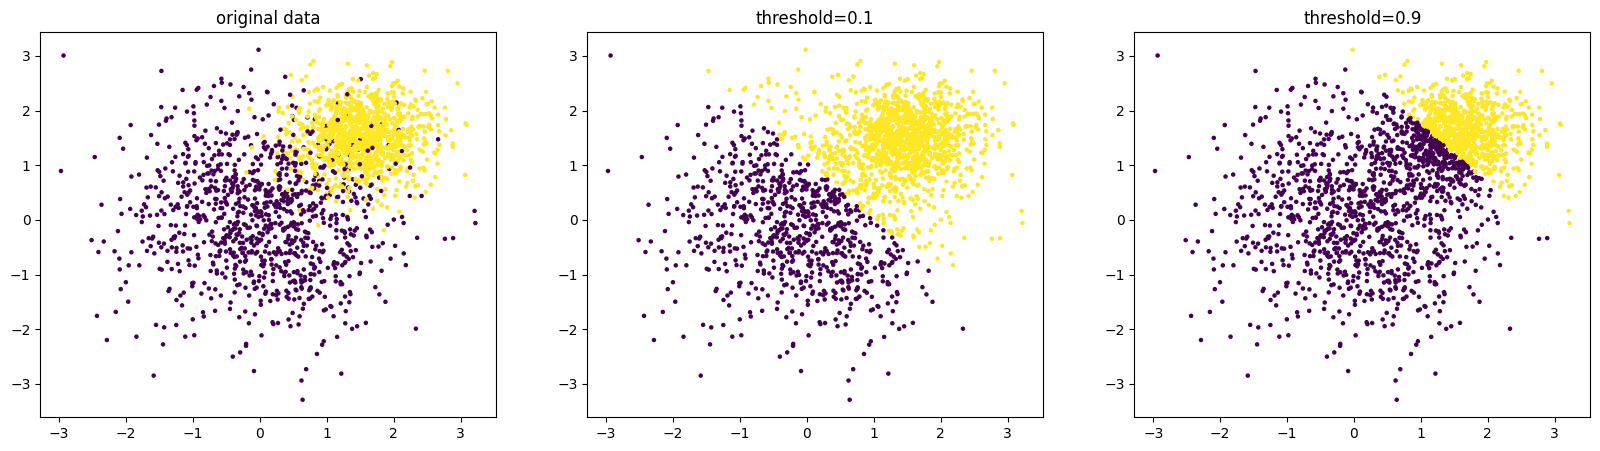

In [67]:
#Matplotlib
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")

plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")

plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9")
plt.show()

###Tuning Threshold
#### Tuning the Classification Threshold with GridSearchCV

####Why Tune the Threshold?

The default threshold of 0.5 may not always give the best results especially when you're optimizing for:
- **Precision** (e.g., fewer false positives)
- **Recall** (e.g., catching more positives)
- **F1-score** (a balance between the two)

By using `Thresholder` inside a `Pipeline`, we can dynamically **tune the threshold** using `GridSearchCV`, just like tuning `C`, `max_depth`, etc.


In [68]:
# Threshold Tuning using Thresholder using Preprocessing(Pipe) and Metrics(GrindSearchCV)

#Pipe
# Define Pipeline with Thresholder (initial threshold=0.1)
# You can change the threshold dynamically using GridSearchCV
# Model here is LogisticRegression (linear classifier)

pipe = Pipeline([
    ('model', Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])


##Metrics
#### GridSearchCV for Threshold Tuning

- `np.linspace(0.1, 0.9, 30)` generates 30 thresholds to test from 0.1 to 0.9
- `param_grid={'model__threshold': ...}` allows GridSearchCV to tune the threshold.
- `scoring`: You're evaluating precision, recall, and accuracy.
- `refit='precision_score'`: Chooses best model based on highest precision.
- `cv=10`: 10-fold cross-validation.

### Accuracy: Should You Trust It?

- ✅ If dataset is **balanced** → Accuracy is fine. meaning the labels are in 50-50
- ❌ If dataset is **imbalanced** → Accuracy is misleading. Use precision, recall, F1 instead.meaning if labels are 20-80 and like that


In [69]:
# GridSearchCV setup to tune threshold
threshold_model = GridSearchCV(
    estimator=pipe, #can be model
    param_grid={'model__threshold': np.linspace(0.1, 0.9, 30)},#fits the theshold in range from 0.1 to 0.9
    scoring={
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score), #Calculating accuracy here is legit
    },
    refit='precision_score', #Precision refitting
    cv=10,
)



###Training metrics

In [70]:
#Train
threshold_model.fit(X,y)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('model',
                                        Thresholder(model=LogisticRegression(),
                                                    threshold=0.1))]),
             param_grid={'model__threshold': array([0.1       , 0.12758621, 0.15517241, 0.18275862, 0.21034483,
       0.23793103, 0.26551724, 0.29310345, 0.32068966, 0.34827586,
       0.37586207, 0.40344828, 0.43103448, 0.45862069, 0.4862069 ,
       0.5137931 , 0.54137931, 0.56896552, 0.59655172, 0...
       0.65172414, 0.67931034, 0.70689655, 0.73448276, 0.76206897,
       0.78965517, 0.81724138, 0.84482759, 0.87241379, 0.9       ])},
             refit='precision_score',
             scoring={'accuracy_score': make_scorer(accuracy_score, response_method='predict'),
                      'precision_score': make_scorer(precision_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

###Matplotlib for metrics

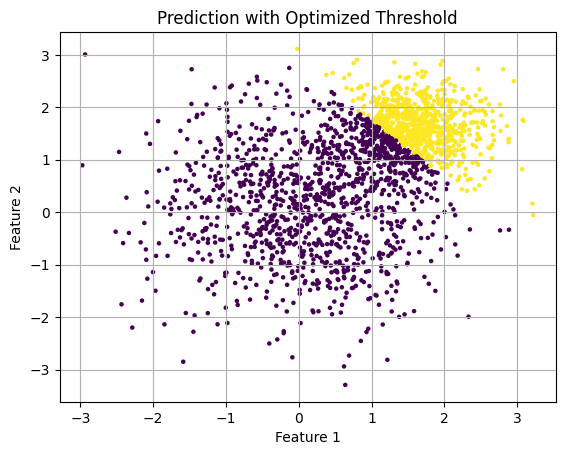

In [71]:
plt.scatter(X[:, 0], X[:, 1], c=threshold_model.predict(X), s=5)
plt.title("Prediction with Optimized Threshold")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()



```
The Thresholder acts like a meta-estimator, because it wraps around another
estimator and modifies the predict() behavior (by changing threshold of
decision function).
So, yes — it is a meta-estimator, even if it’s not from sklearn.ensemble.

```



##Time-Series




###Group Predictor
GroupedPredictor:
A meta-estimator that trains a separate model per group (like per user, region, or time slice).

Dummy Regressor: A simple baseline regressor that predicts the mean of the training targets

make_simpleseries:
Synthetic dataset from sklego.datasets designed to simulate time-series data where grouping matters.

###Importing Required Libraries

In [72]:
from sklego.meta import GroupedPredictor
from sklearn.dummy import DummyRegressor

#Synthetic Datset
from sklego.datasets import make_simpleseries
import pandas as pd

###Creating Synthetic Dataset

In [73]:
#Using make_simpleseries
targets = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(targets))
df = (
    pd.DataFrame({"target": targets, "date": dates})
    .assign(m=lambda d: d.date.dt.month)  # extracting month for grouping
    .reset_index()
)

In [74]:
# GroupedPredictor:
# - Wraps a base model (DummyRegressor here)
# - Trains separate models for each group (month in this case)
# - Think of it like: 12 tiny models for Jan to Dec

model = GroupedPredictor(DummyRegressor(), groups=['m'])


###Training for Grouped Predictor

In [75]:
# Fit the grouped model
model.fit(df[['m']], df['target']) #What the hell i want it to be lik eprevious X and y

GroupedPredictor(estimator=DummyRegressor(), groups=['m'])

###Matplotlib for Grouped Predictor

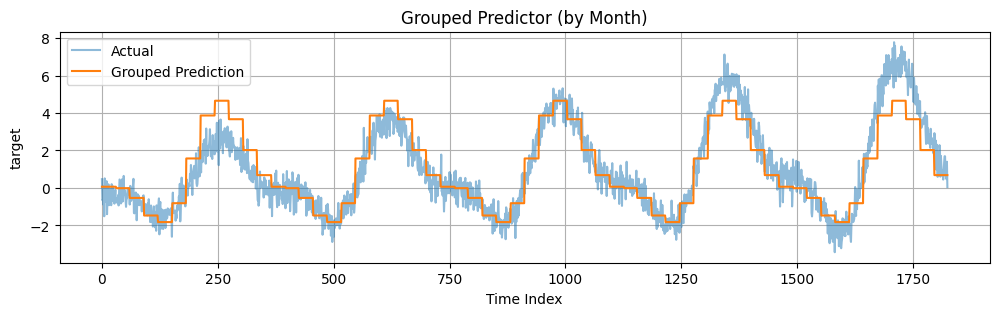

In [76]:

plt.figure(figsize=(12, 3))
plt.plot(df['target'], alpha=0.5, label='Actual')                     # Original signal
plt.plot(model.predict(df[['m']]), label='Grouped Prediction')   # Grouped prediction
plt.legend()
plt.title("Grouped Predictor (by Month)")
plt.xlabel("Time Index")
plt.ylabel("target")
plt.grid(True)
plt.show()


##Decay Estimator:
DecayEstimator gives more weight to recent observations in a dataset
useful when recent data is more relevant .

###Importing Required Libraries

In [77]:
#Importing Decay Estimators and exponential decay
from sklego.meta import DecayEstimator


###Training models

###Model 1 - without decay estimator


In [78]:
# Model 1 no decay applied, simple GroupedPredictor using month-based grouping
model1 = GroupedPredictor(DummyRegressor(), groups=["m"]) # m = months

model1.fit(df[['m']], df['target'])

GroupedPredictor(estimator=DummyRegressor(), groups=['m'])

###Model 2 - with Decay Estimator

In [79]:
#Model 2 — same as above but now with decay logic applied
# This uses DecayEstimator to apply exponentially decreasing weights (decay) within groups
# decay_func='exponential' tells the estimator to use exponential decay
# decay_func controls the decay curve — closer to 1 means slower decay (i.e., newer and older points are weighted more equally)
# Lower values like 0.5 would emphasize newer data more heavily
model2 = GroupedPredictor(
            DecayEstimator(DummyRegressor(),
                           decay_func='exponential',
                           decay_kwargs={'decay_rate': 0.9}),
            groups=['m'])  # Grouping by month
model2.fit(df[['m']], df['target'])  # Even though we predict with index later, fitting still just needs group info




GroupedPredictor(estimator=DecayEstimator(decay_kwargs={'decay_rate': 0.9},
                                          model=DummyRegressor()),
                 groups=['m'])

###Matplotlib for Decay Estimator

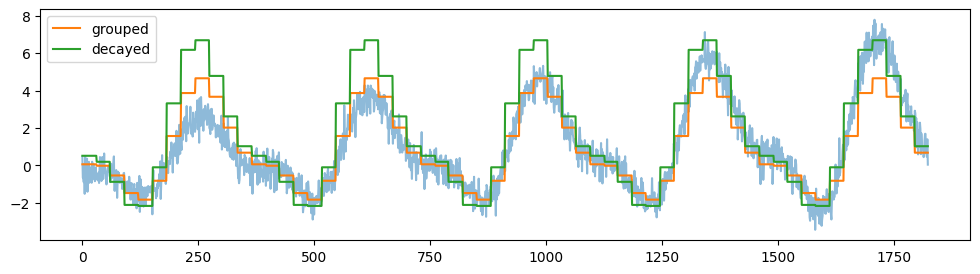

In [80]:
#Matplotlib

plt.figure(figsize=(12, 3))
plt.plot(df['target'], alpha=0.5)  # Actual time-series (ground truth)
plt.plot(model1.predict(df[['m']]), label="grouped")  # Prediction without decay
plt.plot(model2.predict(df[['index', 'm']]), label="decayed")  # Prediction with decay applied
plt.legend()
plt.show()

##Summary: Meta-Estimators in Scikit-learn

This notebook covers **meta-estimators** — high-level models that manage and improve other models internally.

### Covered Concepts:
0. **Voting Classifier**
1. **Thresholding**
2. **Matrics**  
   - Hyperparameter tuning for classification threshold  
   - Multiple scoring metrics used  
   - Decision boundary visualization to understand effect of threshold

3. **TimeSeries **  
   - Useful when data is grouped (e.g., by time, user, etc.)  
   - Trains a different model per group  

4. **DecayEstimator (sklego.meta)**  
   - Applies decay to give more weight to newer data (time-sensitive)  
   - Exponential decay modeled with a `decay_rate` (e.g., 0.9)  




---
## ***Thank you ***

You've just walked through an essential journey of applied machine learning using **Meta-Estimators**.

From the **humble beginnings of introduction**, through the **trenches of preprocessing**, the **battlefield of evaluation metrics**, and finally reaching the **meta-level of estimator **
###**Why All This Matters**

I don’t do this for clicks or clout.
I do this because —  
> "Culture shouldn't exist only for those who can afford it."  
> —  "Hakita" , ULTRAKILL Creator*

This repo, this notebook, this project — **is free**, and will **remain public**.  
No paywall. No gatekeeping. Only growth.

---

##  Navigation

[![➡️ Am_I _Cooked](https://img.shields.io/badge/Project-AM_I_Cooked-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/am-i-cooked)
&nbsp;&nbsp;&nbsp;&nbsp;
[![➡️ neural-network](https://img.shields.io/badge/neural_netwwork-tensorflow-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/tensorflow)

---

## Author
 <p align="left">
  Created and maintained by
  <a href="https://github.com/aypy01" target="_blank">&nbsp Aaditya Yadav</a>&nbsp
  <a href="https://github.com/aypy01" target="_blank">
    <img src="https://img.shields.io/badge/aypy01-000000?style=flat-square&logo=github&logoColor=00FF80" alt="GitHub Badge"/>
  </a>
</p>

</p>
<p align="left">
  <img src="https://readme-typing-svg.demolab.com?font=Fira+Code&duration=3000&pause=500&color=00FF80&center=false&vCenter=false&width=440&lines=Break+Things+First%2C+Understand+Later;Built+to+Debug%2C+Not+Repeat;Learning+What+Actually+Sticks;Code.+Observe.+Refine." alt="Typing SVG" />
</p>

---




## License

This project is licensed under the [![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

---